In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor

## Step 1: load data

In [2]:
local_path = "/home/jwzhang411898961/Dropbox/DataScience/Kaggle/HousingPrice"

train_df = pd.read_csv(local_path + "/train.csv")
test_df = pd.read_csv(local_path + "/test.csv")

## Step 2: merge data

In [3]:
prices = pd.DataFrame({'price': train_df['SalePrice'], \
                       'log(price+1)': np.log1p(train_df['SalePrice'])})
prices.head()

,log(price+1),price
0,12.247699,208500
1,12.109016,181500
2,12.317171,223500
3,11.849405,140000
4,12.429220,250000


In [4]:
y_train = np.log1p(train_df.pop('SalePrice'))
all_df = pd.concat([train_df, test_df], axis=0)

## Step 3：variable transformation

In [5]:
print(all_df['MSSubClass'].dtypes)

int64


In [6]:
all_df['MSSubClass'] = all_df['MSSubClass'].astype(str)
print(all_df['MSSubClass'].dtypes)
print(all_df['MSSubClass'].value_counts())

object
20     1079
60      575
50      287
120     182
30      139
70      128
160     128
80      118
90      109
190      61
85       48
75       23
45       18
180      17
40        6
150       1
Name: MSSubClass, dtype: int64


In [7]:
MSSubclass_dummies_df = pd.get_dummies(all_df['MSSubClass'], prefix='MSSubClass').head()
all_dummy_df = pd.get_dummies(all_df)
print(all_dummy_df.head())

   Id  LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  \
0   1         65.0     8450            7            5       2003   
1   2         80.0     9600            6            8       1976   
2   3         68.0    11250            7            5       2001   
3   4         60.0     9550            7            5       1915   
4   5         84.0    14260            8            5       2000   

   YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2          ...            \
0          2003       196.0       706.0         0.0          ...             
1          1976         0.0       978.0         0.0          ...             
2          2002       162.0       486.0         0.0          ...             
3          1970         0.0       216.0         0.0          ...             
4          2000       350.0       655.0         0.0          ...             

   SaleType_ConLw  SaleType_New  SaleType_Oth  SaleType_WD  \
0               0             0             0            1  

In [8]:
# print(all_dummy_df.isnull().sum().sort_values(ascending = False).head(11))
mean_cols = all_dummy_df.mean()
all_dummy_df = all_dummy_df.fillna(mean_cols)

In [9]:
print(all_dummy_df.isnull().sum().sum())

0


In [10]:
numeric_cols = all_df.columns[all_df.dtypes != 'object']
print(numeric_cols)
numeric_col_means = all_dummy_df.loc[:, numeric_cols].mean()
numeric_col_std = all_dummy_df.loc[:, numeric_cols].std()
all_dummy_df.loc[:, numeric_cols] = \
(all_dummy_df.loc[:,numeric_cols] - numeric_col_means) / numeric_col_std

Index(['Id', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')


## Step 4: 建立模型

In [32]:
# 把数据处理之后，送回训练集和测试集
dummy_train_df = all_dummy_df.iloc[:len(train_df)]
dummy_test_df = all_dummy_df.iloc[len(train_df):]
print(dummy_train_df.shape,dummy_test_df.shape)

# 将DF数据转换成Numpy Array的形式，更好地配合sklearn
X_train = dummy_train_df.values
X_test = dummy_test_df.values

(1460, 304) (1459, 304)


In [33]:
y_train.shape

(1460,)

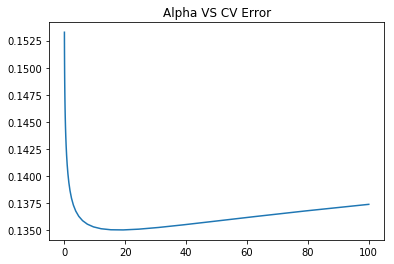

In [34]:
alphas = np.logspace(-3,2,50)
test_scores = []

for alpha in alphas:
    clf = Ridge(alpha)
    test_score = np.sqrt(-cross_val_score(clf,X_train,y_train,cv = 10,scoring = 'neg_mean_squared_error'))
    test_scores.append(np.mean(test_score))
plt.plot(alphas, test_scores)
plt.title('Alpha VS CV Error')
plt.show()

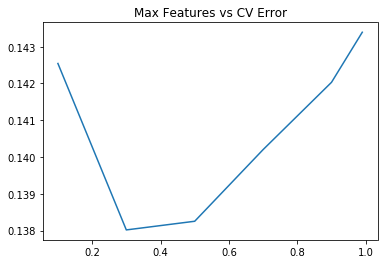

In [35]:
max_features = [.1,.3,.5,.7,.9,.99]
test_scores = []
for max_feat in max_features:
    clf = RandomForestRegressor(n_estimators = 200,max_features = max_feat)
    test_score = np.sqrt(-cross_val_score(clf,X_train,y_train,cv = 5,scoring = 'neg_mean_squared_error'))
    test_scores.append(np.mean(test_score))
plt.plot(max_features,test_scores)
plt.title('Max Features vs CV Error')
plt.show()

## Step 5: Ensemble 

In [36]:
ridge = Ridge(alpha = 15)
rf = RandomForestRegressor(n_estimators = 500,max_features = .3)
ridge.fit(X_train,y_train)
rf.fit(X_train,y_train)

y_ridge = np.expm1(ridge.predict(X_test))
y_rf = np.expm1(rf.predict(X_test))

y_final = (y_ridge + y_rf) / 2

In [38]:
submission_df = pd.DataFrame(data = {'Id':test_df.index,'SalePrice':y_final})
print(submission_df.head(10))
submission_df.to_csv(local_path + '/submission1.csv',columns = ['Id','SalePrice'],index = False)

   Id      SalePrice
0   0  119511.573363
1   1  150913.726425
2   2  173609.841018
3   3  188962.706188
4   4  195185.230625
5   5  175082.476654
6   6  176337.771857
7   7  168274.264983
8   8  182607.592642
9   9  122382.276311
